## Моделирование молекулярной динамики

   - Система: ГЦК решётка $7\times7\times7$ частиц;
   - Постоянная решётки: $a = 1.75~\sigma $;
   - Потенциал взаимодействия: Леннард-Джонс;
   - Начальная температура: $T_i = 1~\varepsilon / k_B$;
   - Конечная температура: $T_f = 1~\varepsilon / k_B$;
   - Скорость охлаждения: $v_T = 0.001~\varepsilon / k_B\tau$;
   - Баростат: Velocity Scaling;
   - Толщина сферического слоя (список Верле): $\Delta r_s = 0.3~\sigma $;
   - Временной шаг: $\Delta t = 0.005~\tau$;
   - Число шагов для охлаждения: 10000;
   - Функция радиального распределения, среднеквадратичное смещение и коэффициенты самодиффузии рассчитывалась через каждые 10000 шагов;
   - Подсчёт состоял из 5499 шагов: 500 на уравновешивание системы при фиксированной температуре и 4999 на усреднение по ансамблям (к первому ансамблю относятся шаги с 1 по 2500 шаг, ко второму - с 2 по 2501 и т.д.);
   - Функция радиального распределения вычислялась как среднее по времени за первые 2500 шагов;

#### Импорт необходимых библиотек

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.figsize'] = [i / 2.54 for i in (15, 15)]
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['mathtext.it'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.labelsize'] = 14

#### Путь к файлам с данными

In [3]:
BASE_DIRECTORY = os.path.dirname(os.getcwd())
PATH_TO_ALL_DATA = os.path.join(BASE_DIRECTORY, 'data')
PATH_TO_ALL_PLOTS = os.path.join(BASE_DIRECTORY, 'plots')
CURRENT_DATA = '2021-03-22'

PATH_TO_CURRENT_DATA = os.path.join(PATH_TO_ALL_DATA, CURRENT_DATA)
PATH_TO_CURRENT_PLOTS = os.path.join(PATH_TO_ALL_PLOTS, CURRENT_DATA)

try:
    os.mkdir(PATH_TO_CURRENT_PLOTS)
except FileExistsError:
    pass

In [4]:
def get_postfix(temperature, pressure, heating_velocity):
    return f'T_{temperature:.5f}_P_{pressure:.5f}_{heating_velocity:.8f}'

def get_rdf_filename(temperature, pressure, heating_velocity):
    return os.path.join(PATH_TO_CURRENT_DATA, f'rdf_{get_postfix(temperature, pressure, heating_velocity)}.csv')

def get_static_structure_filename(temperature, pressure, heating_velocity):
    return os.path.join(PATH_TO_CURRENT_DATA, f'static_structure_factor_{get_postfix(temperature, pressure, heating_velocity)}.csv')

def get_transport_filename(temperature, pressure, heating_velocity):
    return os.path.join(PATH_TO_CURRENT_DATA, f'transport_{get_postfix(temperature, pressure, heating_velocity)}.csv')

parameters_filename = os.path.join(PATH_TO_CURRENT_DATA, 'system_parameters.csv')

In [5]:
plot_filename_postfix = 'cooling'

In [6]:
def save_plot(filename):
    plt.savefig(
        os.path.join(PATH_TO_CURRENT_PLOTS, filename)
    )

#### Параметры, при которых были подчитаны функция радиального распределения

In [7]:
parameters = (
    {'temperature': 1.00259, 'pressure': 0.92877, 'heating_velocity': 0.02,},
    {'temperature': 1.00259, 'pressure': 0.92877, 'heating_velocity': 0.004,},
    {'temperature': 1.00259, 'pressure': 0.92877, 'heating_velocity': 0.0008,},
    {'temperature': 1.00259, 'pressure': 0.92877, 'heating_velocity': 0.00016,},
    {'temperature': 1.00259, 'pressure': 0.92877, 'heating_velocity': 0.000032,},
)

colors = (
    'black',
    'red',
    'green',
    'blue',
    'cyan',
#     'magenta',
#     'purple',
#     'orange',
#     'olive',
#     'yellow',
#     'brown',
#     'pink',
#     'gray',
#     'lime',
#     'slateblue',
#     'crimson',
#     'darkviolet',
#     'sienna',
#     'coral',
)

#### Извлечение значений функции радиального распределения из файлов

In [8]:
rdf_data = pd.DataFrame(columns=['radius'])
# static_structure_data = pd.DataFrame(columns=['wave_number'])
msd_data = pd.DataFrame(columns=['time'])
vel_autocor_data = pd.DataFrame(columns=['time'])
einstein_diffusion_data = pd.DataFrame(columns=['time'])
green_kubo_diffusion_data = pd.DataFrame(columns=['time'])

for parameter in parameters:
    df = pd.read_csv(
        get_rdf_filename(**parameter),
        sep=';',
    )
    rdf_data = rdf_data.merge(
        right=df,
        how='outer',
        on='radius',
    )
#     df = pd.read_csv(
#         get_static_structure_filename(**parameter),
#         sep=';',
#     )
#     static_structure_data = static_structure_data.merge(
#         right=df,
#         how='outer',
#         on='wave_number',
#     )
    df = pd.read_csv(
        get_transport_filename(**parameter),
        sep=';',
    )
    msd_data = msd_data.merge(
        right=df[['time', 'msd']],
        how='outer',
        on='time',
    )
    vel_autocor_data = vel_autocor_data.merge(
        right=df[['time', 'velocity_autocorrelation']],
        how='outer',
        on='time',
    )
    einstein_diffusion_data = einstein_diffusion_data.merge(
        right=df[['time', 'einstein_diffusion']],
        how='outer',
        on='time',
    )
    green_kubo_diffusion_data = green_kubo_diffusion_data.merge(
        right=df[['time', 'green_kubo_diffusion']],
        how='outer',
        on='time',
    )
    heating_velocity = parameter['heating_velocity']
    
    rdf_data = rdf_data.rename(columns={'rdf': f'{heating_velocity:.8f}'})
#     static_structure_data = static_structure_data.rename(columns={'static_structure_factor': f'{heating_velocity:.8f}'})
    msd_data = msd_data.rename(columns={'msd': f'{heating_velocity:.8f}'})
    vel_autocor_data = vel_autocor_data.rename(columns={'velocity_autocorrelation': f'{heating_velocity:.8f}'})
    einstein_diffusion_data = einstein_diffusion_data.rename(columns={'einstein_diffusion': f'{heating_velocity:.8f}'})
    green_kubo_diffusion_data = green_kubo_diffusion_data.rename(columns={'green_kubo_diffusion': f'{heating_velocity:.8f}'})

rdf_data

,radius,0.02000000,0.00400000,0.00080000,0.00016000,0.00003200
0,0.01,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.02,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.03,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.04,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.05,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
607,6.08,1.003005,1.000674,1.002670,1.002881,1.001362
608,6.09,1.003925,1.001636,1.002135,1.002541,0.999662
609,6.10,1.003637,1.001089,1.003295,1.002663,0.999833
610,6.11,1.004052,1.002308,1.002344,1.002414,0.998986


#### Графики функций радиального распределения $g(\textbf{r})$ при различных температурах

$$g(\textbf{r})=\dfrac{V}{N^2}\left<\sum_{i}{\sum_{j\ne i}{\delta(\textbf{r}-\textbf{r}_{ij})}}\right>$$

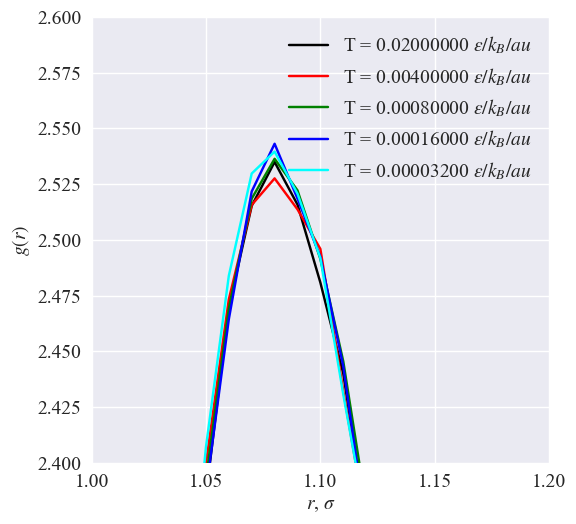

In [9]:
plt.rcParams['font.size'] = 14
for i, parameter in enumerate(parameters):
    current_rdf = rdf_data[f'{parameter["heating_velocity"]:.8f}']
    plt.plot(
        rdf_data['radius'],
        rdf_data[f'{parameter["heating_velocity"]:.8f}'],
        label=f'T = {parameter["heating_velocity"]:.8f} $\epsilon / k_B / \tau $',
        color=colors[i],
    );
    
plt.xlabel('$r$, $\sigma$');
plt.ylabel('$g(r)$');
plt.xlim(
    left=1.0, 
    right=1.2,
);
plt.ylim(
    bottom=2.4, 
    top=2.6,
);
plt.legend();

save_plot(f'rdf_{plot_filename_postfix}.png')

#### Временная зависимость среднеквадратичного смещения $\left<\Delta r^2(t)\right>$ при различных температурах

$$\left<\Delta r^2(t)\right>=\dfrac{1}{N}\sum_{i=1}^{N}{\left|\textbf{r}_i(t)-\textbf{r}_i(0)\right|^2}$$

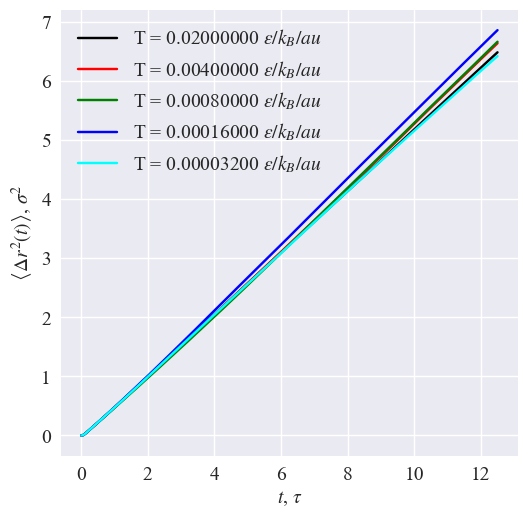

In [10]:
for i, parameter in enumerate(parameters):
    plt.plot(
        msd_data['time'],
        msd_data[f'{parameter["heating_velocity"]:.8f}'],
        label=f'T = {parameter["heating_velocity"]:.8f} $\epsilon / k_B / \tau $',
        color=colors[i],
    );
    
plt.xlabel(r'$t$, $\tau $');
plt.ylabel(r'$\left<\Delta r^2(t)\right>$, $\sigma^2$');
plt.xlim(
#     left=0, 
#     right=5,
);
plt.ylim(
#     bottom=0, 
#     top=7,
);
plt.legend();

save_plot(f'msd_{plot_filename_postfix}.png')

#### Временная зависимость автокорреляционнной функции скорости $\Psi(t)$ при различных температурах

$$\Psi(t) = \dfrac{1}{N}\left<\sum_{j=1}^N{\vec{v}_j(t)\vec{v}_j(0)}\right>$$

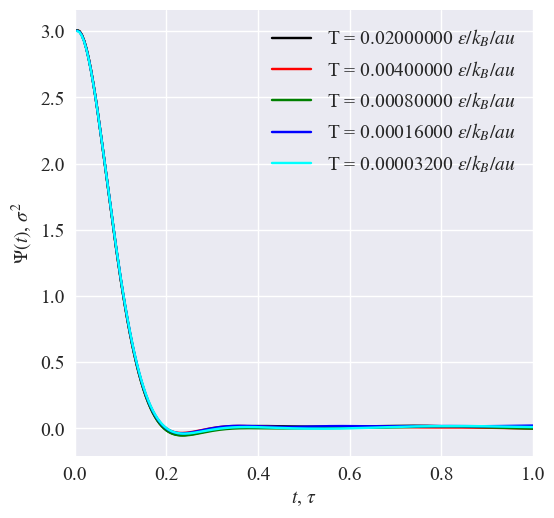

In [11]:
for i, parameter in enumerate(parameters):
    plt.plot(
        vel_autocor_data['time'],
        vel_autocor_data[f'{parameter["heating_velocity"]:.8f}'],
        label=f'T = {parameter["heating_velocity"]:.8f} $\epsilon / k_B / \tau $',
        color=colors[i],
    );
    
plt.xlabel(r'$t$, $\tau $');
plt.ylabel(r'$\Psi(t)$, $\sigma^2$');
plt.xlim(
    left=0, 
    right=1,
);
plt.ylim(
#     bottom=0, 
#     top=20,
);
plt.legend();

save_plot(f'vel_autocorr_{plot_filename_postfix}.png')

#### Временная зависимость коэффициента самодиффузии $D$, вычисленного через соотношение Эйнштейна, при различных температурах

$$D_E(t)=\dfrac{\left<\left<\Delta r^2\right>\right>}{6t}=\dfrac{1}{6tN}\left<\sum_{i=1}^{N}\left|\textbf{r}_i(t)-\textbf{r}_i(0)\right|^2\right>$$

$$D=\lim_{t\rightarrow\infty}{D_E(t)}$$

In [12]:
einstein_diffusion = np.zeros(len(parameters), dtype=np.float)
green_kubo_diffusion = np.zeros(len(parameters), dtype=np.float)

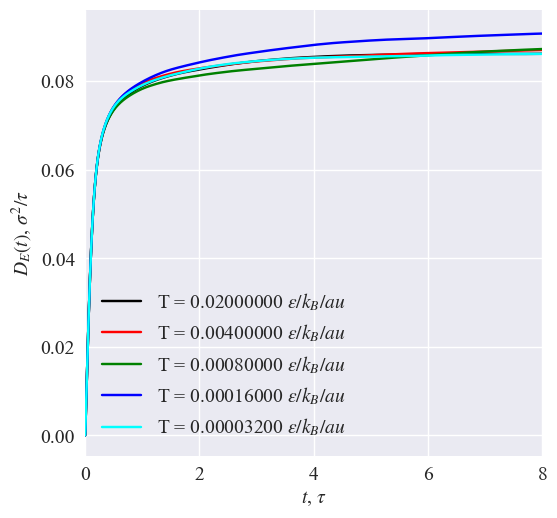

In [13]:
for i, parameter in enumerate(parameters):
    diff_data = einstein_diffusion_data[f'{parameter["heating_velocity"]:.8f}'].values
    plt.plot(
        einstein_diffusion_data['time'].values,
        diff_data, 
        label=f'T = {parameter["heating_velocity"]:.8f} $\epsilon / k_B / \tau $',
        color=colors[i],
    );
    einstein_diffusion[i] = diff_data[-1]
    
plt.xlabel(r'$t$, $\tau$');
plt.ylabel(r'$D_E(t)$, $\sigma^2 / \tau$');
plt.xlim(
    left=0, 
    right=8,
);
plt.ylim(
#     bottom=0, 
#     top=0.25,
);
plt.legend();

save_plot(f'diffusion_einstein_{plot_filename_postfix}.png')

#### Временная зависимость коэффициента самодиффузии $D$, вычисленного через соотношение Грина-Кубо, при различных температурах

$$D_{GK}(t)=\dfrac{1}{3}\int_{0}^{t}{\Psi(\tau)d\tau}=\dfrac{1}{3N}\int_{0}^{t}{\left<\sum_{j=1}^N{\vec{v}_j(\tau)\vec{v}_j(0)}\right>d\tau}$$

$$D=\lim_{t\rightarrow\infty}{D_{GK}(t)}$$

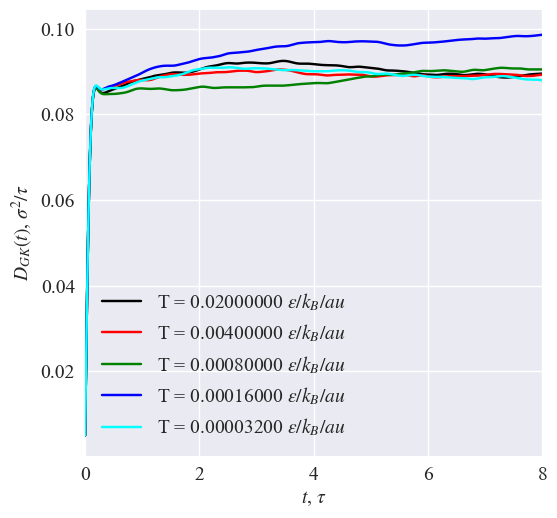

In [14]:
for i, parameter in enumerate(parameters):
    diff_data = green_kubo_diffusion_data[f'{parameter["heating_velocity"]:.8f}'].values
    plt.plot(
        green_kubo_diffusion_data['time'].values,
        diff_data, 
        label=f'T = {parameter["heating_velocity"]:.8f} $\epsilon / k_B / \tau $',
        color=colors[i],
    );
    green_kubo_diffusion[i] = diff_data[-1]
    
plt.xlabel(r'$t$, $\tau$');
plt.ylabel(r'$D_{GK}(t)$, $\sigma^2 / \tau$');
plt.xlim(
    left=0, 
    right=8,
);
plt.ylim(
#     bottom=0, 
#     top=0.27,
);
plt.legend();

save_plot(f'diffusion_green_kubo_{plot_filename_postfix}.png')

#### Сравнение коэффициентов самодиффузии, вычисленных через соотношения Эйнштейна и Грина-Кубо

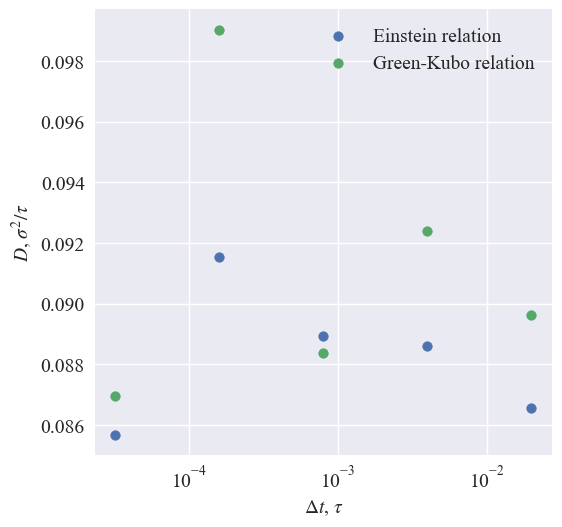

In [15]:
heating_velocities = [parameter["heating_velocity"] for parameter in parameters]

plt.scatter(
    heating_velocities,
    einstein_diffusion, 
    label='Einstein relation',
);
plt.scatter(
    heating_velocities,
    green_kubo_diffusion, 
    label='Green-Kubo relation',
); 
plt.xlabel(r'$\Delta t$, $\tau$');
plt.ylabel(r'$D$, $\sigma^2 / \tau$');
plt.xscale('log');
plt.legend(markerscale=1);
plt.show();

save_plot(f'diffusion_comparing_{plot_filename_postfix}.png')

#### Извлечение параметров системы из файла

In [16]:
system_parameters = pd.read_csv(parameters_filename, sep=';')

for column in system_parameters.columns:
    system_parameters[column] = system_parameters[column].round(5)

system_parameters

,temperature,pressure,system_kinetic_energy,potential_energy,total_energy,virial,msd,diffusion
0,1.00000,-2.18977,2057.2207,-7984.3115,-5927.0910,-16190.59100,0.00007,0.00250
1,0.99962,-2.17742,2055.6785,-7977.0225,-5921.3438,-16119.39100,0.00030,0.00500
2,0.99925,-2.15446,2054.0503,-7961.4385,-5907.3880,-15989.52300,0.00067,0.00749
3,0.99883,-2.12541,2052.0251,-7946.1465,-5894.1210,-15825.27800,0.00120,0.00999
4,0.99827,-2.08932,2049.3510,-7929.9375,-5880.5864,-15620.88800,0.00187,0.01247
...,...,...,...,...,...,...,...,...
9995,1.00095,0.94026,2055.7178,-6525.8003,-4470.0825,1073.90940,62.92180,0.20982
9996,1.00120,0.94103,2056.8616,-6524.8516,-4467.9900,1075.86780,62.82878,0.20949
9997,1.00153,0.93979,2058.5234,-6525.6406,-4467.1170,1065.71520,62.93075,0.20981
9998,1.00204,0.93578,2060.8513,-6528.8220,-4467.9707,1038.95100,62.93094,0.20979


<Figure size 590.551x590.551 with 0 Axes>

In [17]:
times = (system_parameters.index + 1) * 0.005

#### Зависимость температуры системы от времени

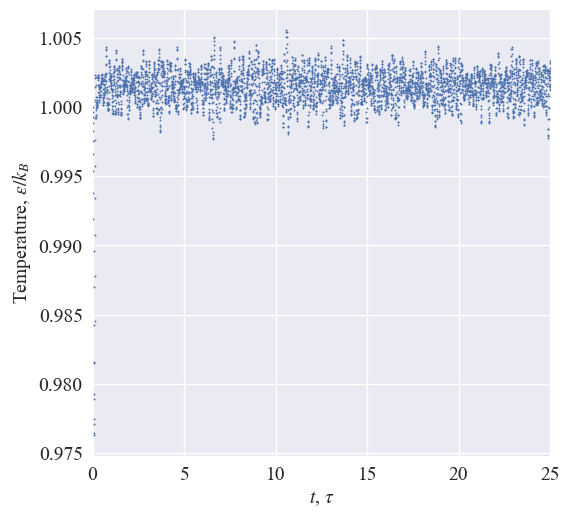

In [18]:
plt.scatter(
    times,
    system_parameters['temperature'],
    s=1,
);
plt.xlabel(r'$t$, $\tau$');
plt.ylabel(r'Temperature, $\epsilon / k_B$');

plt.xlim(
    left=0,
    right=25,
);
plt.ylim(
#     bottom=2.75,
#     top=5,
);

save_plot(f'temperature_{plot_filename_postfix}.png')

#### Зависимость давления системы от времени

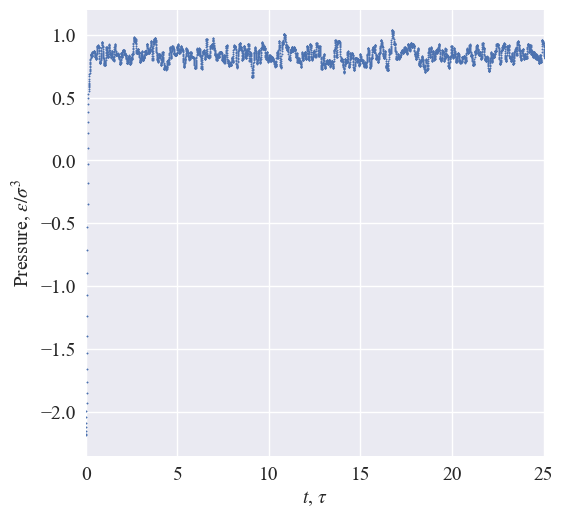

In [19]:
plt.scatter(
    times,
    system_parameters['pressure'],
    s=1,
);
plt.xlabel(r'$t$, $\tau$');
plt.ylabel(r'Pressure, $\epsilon / \sigma^3 $');

plt.xlim(
    left=0,
    right=25,
);
plt.ylim(
#     bottom=0,
#     top=25,
);
save_plot(f'pressure_{plot_filename_postfix}.png')

#### Зависимость кинетической энергии системы от времени

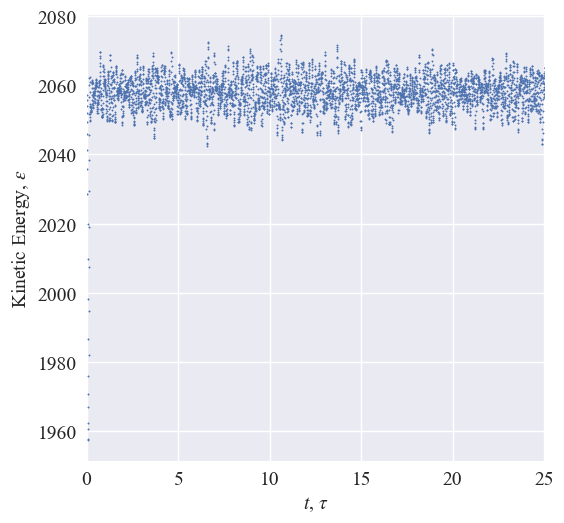

In [20]:
plt.scatter(
    times,
    system_parameters['system_kinetic_energy'],
    s=1,
);
plt.xlabel(r'$t$, $\tau$');
plt.ylabel(r'Kinetic Energy, $\epsilon$');

plt.xlim(
    left=0,
    right=25,
);
plt.ylim(
#     bottom=-5000,
#     top=20000,
);
save_plot(f'kinetic_energy_{plot_filename_postfix}.png')

#### Зависимость потенциальной энергии системы от времени

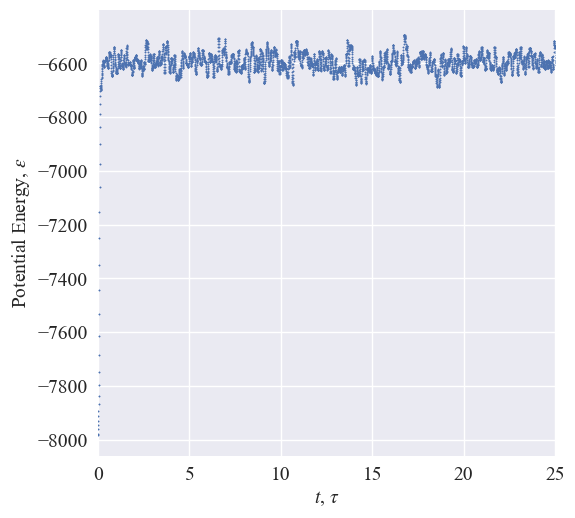

In [21]:
plt.scatter(
    times,
    system_parameters['potential_energy'],
    s=1,
);
plt.xlabel(r'$t$, $\tau$');
plt.ylabel(r'Potential Energy, $\epsilon$');

plt.xlim(
    left=0,
    right=25,
);
plt.ylim(
#     bottom=-5000,
#     top=20000,
);
save_plot(f'potential_energy_{plot_filename_postfix}.png')

#### Зависимость полной энергии системы от времени

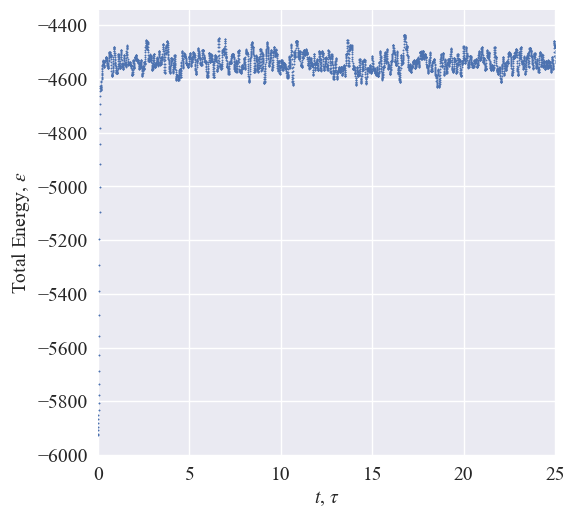

In [22]:
plt.scatter(
    times,
    system_parameters['total_energy'],
    s=1,
);
plt.xlabel(r'$t$, $\tau$');
plt.ylabel(r'Total Energy, $\epsilon$');

plt.xlim(
    left=0,
    right=25,
);
plt.ylim(
#     bottom=-5000,
#     top=20000,
);
save_plot(f'total_energy_{plot_filename_postfix}.png')

#### Энергии на одном графике

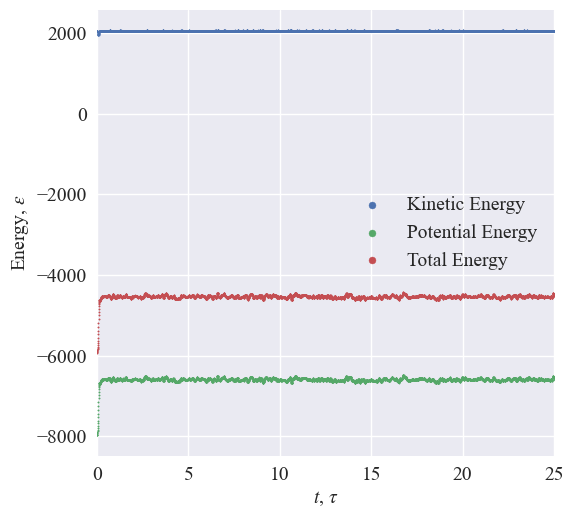

In [23]:
plt.scatter(
    times,
    system_parameters['system_kinetic_energy'],
    s=1,
    label='Kinetic Energy',
);
plt.scatter(
    times,
    system_parameters['potential_energy'],
    s=1,
    label='Potential Energy',
);
plt.scatter(
    times,
    system_parameters['total_energy'],
    s=1,
    label='Total Energy',
);

plt.xlabel(r'$t$, $\tau$');
plt.ylabel(r'Energy, $\epsilon$');
plt.legend(markerscale=5);

plt.xlim(
    left=0,
    right=25,
);
plt.ylim(
#     bottom=-10000,
#     top=6000,
);
save_plot(f'all_energies_{plot_filename_postfix}.png')